## 1. Import the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# We set up Matplotlib to display plots directly in the notebook:
%matplotlib inline

import seaborn as sns

In [2]:
heart = pd.read_csv('./data/heart.csv')

FileNotFoundError: [Errno 2] No such file or directory: './heart.csv'

In [ ]:
heart.head()

In [ ]:
df = heart

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

## 2. Explore the data

In [ ]:
X.info()

In [ ]:
X.describe()

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
ProfileReport(df, minimal=True)

In [ ]:
#sns.pairplot(df, hue='HeartDisease')
#plt.show()

#### Notes so far
Given what we have explored so far, we can observe the following:
- 172 have 0 as a cholesterol-value, which isn't possible, so we need to fix that
- 'Oldpeak' also has a significant spike in zeros - which can be worth looking into
- There are more patients at risk for heart disease instead of those who aren't

## 3. Feature Engineering

#### 3.1 Converting datatypes

In the dataset, we have five different columns which needs to be converted to numerical values:
- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

#### Sex

Here we only need to convert the 'M' and 'F' values into ones and zeros

In [ ]:
X['Sex'].unique()

In [ ]:
convertedSex = np.array([0 if i == 'F' else 1 for i in X['Sex']])
convertedSex = convertedSex.tolist()
X['Sex'] = convertedSex
X.head()

#### Chest Pain Type, RestingECG, ExerciseAngina & ST Slope

Because these columns contains more than two disctinct values, we need to one hot encode them. What this means is that each distinct value gets its own column.

In [ ]:
X['ChestPainType'].unique()

In [ ]:
X['ChestPainType'].value_counts()

In [ ]:
X = pd.get_dummies(X, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype=int)

In [ ]:
print(f'''ChestPainType
ASY\t{X['ChestPainType_ASY'].to_list().count(1)}
NAP\t{X['ChestPainType_NAP'].to_list().count(1)}
ATA\t{X['ChestPainType_ATA'].to_list().count(1)}
TA\t{X['ChestPainType_TA'].to_list().count(1)}
      ''')

#### 3.2 Handling missing values

In the column 'cholesterol', there are a significant amount of zeros, which isn't possible. You can't have zero cholesterol. Therefore we need to convert them into values that can make sense. 

To handle this we will use a tool called Iterative Imputer, which tries to calculate a value for Cholesterol based on other columns. Here we will try to achieve a skewness and kurtosis similar to the one achieved when removing the zeros.

In [ ]:
no_zeros = X[X['Cholesterol'] != 0]['Cholesterol']
no_zeros.hist(bins=30)
plt.show()

After imputing the missing values we want to maintain a similar skewness, kurtosis and mean to the ones below.

In [ ]:
print(no_zeros.skew())
print(no_zeros.kurtosis())
print(no_zeros.mean())

What we could have done was to replace all the zeros with the mean of the values (199), but instead we're going to try to calculate a reasonable value for each patients cholesterol. 

To calculate this we choose Age, Max Heart Rate and Resting Blood Pressure to avoid overfitting the imputations.  

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select relevant columns
cols_to_use = ['Age', 'MaxHR', 'RestingBP', 'Cholesterol']
X_subset = X[cols_to_use]

In [ ]:
X_subset

In [ ]:
# Initialize imputer
from sklearn.ensemble import RandomForestRegressor

imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=15, random_state=42)

In [ ]:
# Change zeros in Cholesterol to null
X_subset.loc[X_subset['Cholesterol'] == 0, 'Cholesterol'] = np.nan

In [ ]:
# Perform imputation
imputer.fit(X_subset)

In [ ]:
X_imputed = pd.DataFrame(imputer.transform(X_subset), columns=cols_to_use)

In [ ]:
print(X_imputed['Cholesterol'].skew())
print(X_imputed['Cholesterol'].kurtosis())
print(X_imputed['Cholesterol'].mean())

All of the values have stayed within the same range as before

In [ ]:
X_imputed['Cholesterol'].hist(bins=30)

In [ ]:
sns.lmplot(x='Cholesterol', y='MaxHR', data=X_imputed)
plt.show()

In [ ]:
X['Cholesterol'] = X_imputed['Cholesterol']

In [ ]:
X.info()

### 3.3 Scaling the data

Earlier when i was testing out the model on the data with the same preprocessing as above, i got the following error:  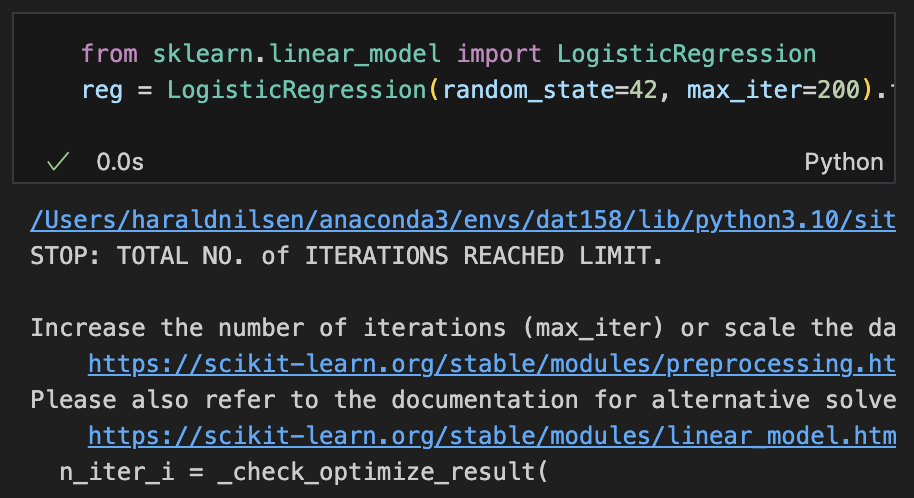. 


When the error says that the algorithm didn't converge, the data wasn't sufficient to make the model predict well. This means that the data has room for improvement. To fix this we can try scaling the data.

In [ ]:
ProfileReport(X, minimal=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

## 4. Model Selection

Our next step is to find a machine learning model that we will use to predict whether a patient is at risk of obtaining a severe heart disease. 

Our task is a classification task, meaning that we we won't try to predict a numeric value, but rather use all the information we have to predict either True or False. For this we have many different models we can test.

But before we go ahead finding a model, lets recap what we've done so far:
1. We imported the dataset from our local machine.
2. We explored the data at hand, getting a better picture of the qualities of the data.
3. When exploring the data we found that some of the columns had skewed data and some of the data weren't numerical, so we handled this.

---

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

---

Ok, so given that our task is a classification task we can narrow down our options. Let's start with the simple models and work our way down.

### Simple models
#### Logistic Regression



In [ ]:
from sklearn.linear_model import LogisticRegression
reg_clf = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gauss_clf = GaussianNB()

### More advanced models

#### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
svc_clf = SVC(gamma='auto')

#### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)

### 4.1 Evaluating performances

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
k = 10

In [ ]:
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#### The simpler models

In [ ]:
# Logistic Regression
reg_score = cross_val_score(reg_clf, X_train, y_train)

# Naive bayes
bayes_score = cross_val_score(gauss_clf, X_train, y_train)

In [ ]:
reg_average_accuracy = np.mean(reg_score)
print(f"Logistic Regression Average Accuracy: {reg_average_accuracy:.4f}")

bayes_average_accuracy = np.mean(bayes_score)
print(f"Naive Bayes Average Accuracy: {bayes_average_accuracy:.4f}")

#### The more advanced models

In [ ]:
# Support vector machine
svm_score = cross_val_score(svc_clf, X_train, y_train)

# Gradient boost
gb_score = cross_val_score(gb_clf, X_train, y_train)

In [ ]:
svm_average_accuracy = np.mean(svm_score)
print(f"Support Vector Machine Average Accuracy: {svm_average_accuracy:.4f}")

gb_average_accuracy = np.mean(gb_score)
print(f"Gradient Boost Average Accuracy: {gb_average_accuracy:.4f}")

## 5. Hyperparameter tuning

In [ ]:
gb_clf.get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 50, None],
    'min_samples_leaf': [1, 2],
}

In [ ]:
# Setup grid search
gs_class = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

In [ ]:
# Fit the model
gs_class.fit(X_train, y_train)

In [ ]:
best_reg = gs_class.best_estimator_


In [ ]:
# Best parameters
best_params = gs_class.best_params_
print(f"Best Parameters: {best_params}")

In [ ]:
from sklearn.metrics import f1_score

prediction = best_reg.predict(X_test)

f1_score(y_true=y_test, y_pred=prediction)

## 6. Viewing feature importance

In [ ]:
feature_importance = best_reg.feature_importances_

Map feature importances to the corresponding feature names

In [ ]:
features = list(X.columns)
feature_importance_dict = dict(zip(features, feature_importance))

Sort features based on importance

In [ ]:
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

Plot feature importances

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in sorted_features], y=[x[0] for x in sorted_features])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## 7. Pipeline

Importing necessary modules

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Applying the sex convertion from 'M' and 'F' to 1 and 0:

In [ ]:
def convert_sex(X):
    X = X.copy()
    X['Sex'] = np.array([0 if i == 'F' else 1 for i in X['Sex']])
    return X

In [ ]:
sex_transformer = FunctionTransformer(convert_sex)

One hot encoding the columns with textual representation:

In [ ]:
def encode_text(X):
    X = X.copy()
    X = pd.get_dummies(X, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype=int)
    return X

In [ ]:
text_transformer = FunctionTransformer(encode_text)

Imputing missing values in Cholesterol:

In [ ]:
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=15, random_state=42)

In [ ]:
cols_to_impute = ['Age', 'MaxHR', 'RestingBP', 'Cholesterol']

In [ ]:
X_cols_to_impute = X[cols_to_impute]

In [ ]:
imputer.fit(X_cols_to_impute)

In [ ]:
imputer_transformer = ColumnTransformer(
    transformers=[
        ('imputer', imputer, cols_to_impute)
    ],
    remainder='passthrough'
)

Add missing columns

In [ ]:
from transformers import AlignColumnsTransformer

Create pipeline

In [ ]:
pipeline = Pipeline(steps=[
    ('convert_sex',sex_transformer),
    ('encoding', text_transformer),
    ('align_columns', AlignColumnsTransformer()),
    ('imputer', imputer_transformer),
    ('scaler', StandardScaler()),
    ('classifier', best_reg)
])

Lets check that the pipeline works as intended

In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
X_test

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
df = pd.DataFrame(columns=X.columns)

df.loc[0] = [
        20, 
        'M', 
        'ATA', 
        140,
        180, 
        0, 
        'Normal', 
        156, 
        'N', 
        1.0, 
        'Up'
    ]

pipeline.predict(df)

In [ ]:
X_test.head()

In [ ]:
df.head()

In [ ]:
f1_score(y_true=y_test, y_pred=y_pred)

## 8. Making a web interface

The reason we check the importance is to define which features we need to ask for when making the interface. 

First let's make a function that the web interface can use

In [ ]:
import gradio as gr

def predictstay(age, sex, chestpaintype, resting_bp, cholesterol, fasting_bs, resting_ecg, max_hr, exercise_angina, oldpeak, st_slope):
    new_patient = pd.DataFrame({
        'Age': [age], 
        'Sex': [sex], 
        'ChestPainType': [chestpaintype], 
        'RestingBP': [resting_bp],
        'Cholesterol': [cholesterol], 
        'FastingBS': [fasting_bs], 
        'RestingECG': [resting_ecg], 
        'MaxHR': [max_hr], 
        'ExerciseAngina': [exercise_angina], 
        'Oldpeak': [oldpeak], 
        'ST_Slope': st_slope
    })
    
    y_pred = pipeline.predict(new_patient)

    return 'At risk' if y_pred == 1 else 'Not at risk'
    
demo = gr.Interface(
    fn=predictstay, 
    inputs=[
        gr.Dropdown(list(range(27,77))),
        gr.Dropdown(['M', 'F']),
        gr.Dropdown(['ATA', 'NAP', 'ASY', 'TA']),
        gr.Slider(70, 170),
        gr.Slider(150, 300),
        gr.Dropdown([1, 0]),
        gr.Dropdown(['Normal', 'ST', 'LVH']),
        gr.Slider(70, 180),
        gr.Dropdown(['n', 'y']),
        gr.Slider(0, 5),
        gr.Dropdown(['Up', 'Flat', 'Down'])
        ], 
    outputs="text")
    
demo.launch()  